# S&P 500 Predictions from Headline News

## Initial Data Cleaning and Transformation

### Extract, Transform, and Load the Headlines Data

We'll first import the full news headlines data set, which is over 420,000 data points each with many features, and transform it with Pandas. Specifically, we'll eliminate unnecessary features (columns), extract only those data points categorized as "business", convert the Unix timestamp into a date string that comports with the S&P data set, and sample the dataset into a uniform count per date. This should leave us with a manageable, yet still sizeable set from which to model.

In [1]:
import pandas as pd

# change this variable based on the existence of the compact_headlines.csv
WRITTEN = False

def read_write_headlines():
    """
    Reads the large headlines csv, transforms it, samples it, and writes the compacted form
    as a csv.
    """
    # read the data file
    headlines_full = pd.read_csv("./data/full_headlines.csv")
    # slice the useful headlines into a new dataframe
    headlines_compact = headlines_full.loc[:, ['ID', 'TITLE', 'CATEGORY', 'TIMESTAMP']]
    # keep only those headlines categorized as 'b' for business
    headlines_biz = headlines_compact.loc[headlines_compact['CATEGORY'] == 'b']
    # then transform the unixtime to a datetime object and extract the Y-M-D as a string
    headlines_biz['TIMESTAMP'] = headlines_biz['TIMESTAMP'].map(
        lambda x: pd.to_datetime(x, unit='ms')).map(lambda x: x.strftime('%Y-%m-%d'))
    
    # write transformed data to file to persist
    headlines_biz.to_csv("./data/biz_headlines.csv", index=False)

    
if not WRITTEN:
    read_write_headlines()

if WRITTEN:
    headlines = pd.read_csv("./data/biz_headlines.csv")
    print "Feature      Number of Data Points"
    print "---------------------------------"
    print headlines.count()
    print "================================="
    print headlines.head()

Feature      Number of Data Points
---------------------------------
ID           115967
TITLE        115967
PUBLISHER    115966
CATEGORY     115967
TIMESTAMP    115967
dtype: int64
   ID                                              TITLE          PUBLISHER  \
0   1  Fed official says weak data caused by weather,...  Los Angeles Times   
1   2  Fed's Charles Plosser sees high bar for change...           Livemint   
2   3  US open: Stocks fall after Fed official hints ...       IFA Magazine   
3   4  Fed risks falling 'behind the curve', Charles ...       IFA Magazine   
4   5  Fed's Plosser: Nasty Weather Has Curbed Job Gr...          Moneynews   

  CATEGORY   TIMESTAMP  
0        b  2014-03-10  
1        b  2014-03-10  
2        b  2014-03-10  
3        b  2014-03-10  
4        b  2014-03-10  


### Quick Visual of The Transformed Headline Data

Plotting the number of headlines by day over the six month time-frame of the dataset. This line chart shows that the data is now unevenly distributed over the dates, of which there are 102, with a max of 2449 headlines on one day and a min of 61 on another. For our purposes, we'll trim the number of headlines to an even 60 per day, producing a sample size of 6120 headlines, which should be large enough to train and test our models. This is also a good time to note that we're also missing headlines on some days! That's definitely something we'll have to address later when producing our labels for these features.

Total Number of Headline Dates:  102
Maximum Number of Headlines on One Day:  2449
Minimum Number of Headlines on One Day:  61


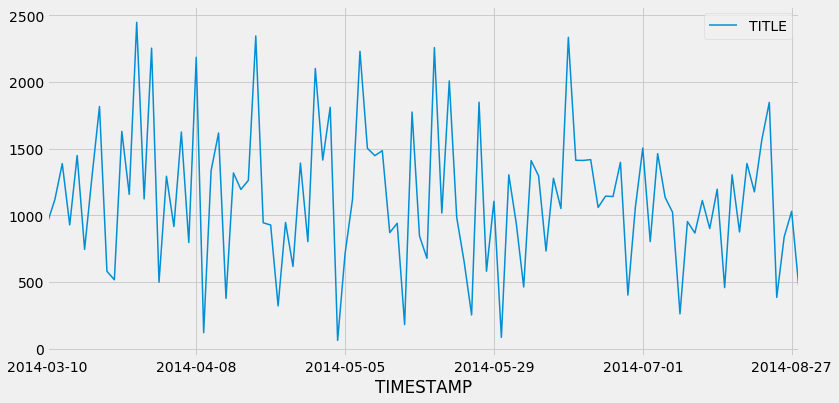

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use matplotlib's built-in 538 stylesheet (like the blog)
plt.style.use('fivethirtyeight')

# slice-off title and date, then group the title count by date
headlines_by_date = headlines[['TITLE', 'TIMESTAMP']].groupby('TIMESTAMP').count()

headlines_by_date.plot(figsize=(12,6), linewidth=1.5)

print 'Total Number of Headline Dates: ', headlines_by_date['TITLE'].count()
print 'Maximum Number of Headlines on One Day: ', headlines_by_date['TITLE'].max()
print 'Minimum Number of Headlines on One Day: ', headlines_by_date['TITLE'].min()

### Helper Function for Sampling

Pandas has a built-in sampling method, but it's not going to produce an even distribution of headlines for each day where we have data. Likewise, I've created a simple date-driven sampler function below.

In [3]:
# helper sampling function
def sampler(df, sample_size_per_day):
    """
    Samples a headlines dataframe and produces a new dataframe of the specified sample size,
    using the headline date as the value over which to evenly distribute the sample.
    """
    # values to track date iteration
    each_date_count = 1
    last_date = None
    # init the sample with the first value of the given dataframe
    sampled_df = None
    
    for idx, row in df.iterrows():
        current_date = row['TIMESTAMP']
        
        # init sampled dataframe and last date variable
        if idx == 0:
            sampled_df = df.iloc[:1]
            last_date = current_date
        
        # append the row to the sample if we are within the date sample window
        elif last_date == current_date and each_date_count < sample_size_per_day:
            sampled_df = sampled_df.append(row)
            each_date_count += 1
        
        # if we are at a new date, append the row but reset the sample window
        elif last_date != current_date:
            sampled_df = sampled_df.append(row)
            last_date = current_date
            each_date_count = 1

    return sampled_df

### Extract Headlines for Further Transformation

Next up, we're going to extract the headlines themselves from the rest of the dataframe, so that we can prepare it for modeling. This involves two steps: (1) sampling a uniform number of headlines for each date (we'll use 60, which is one below our dataset minimum), and (2) joining those headlines together so each date has one headlines feature.

In [4]:
# run the compact headlines data (biz news) through the sampler fn to reduce it to 6120
# then extract the three columns we want to keep (ID, Title, Timestamp)
sampled_headlines = sampler(headlines, 60).loc[:, ['ID', 'TITLE', 'TIMESTAMP']]

joined_dates = []
joined_texts = []
join_date = sampled_headlines.ix[0, 'TIMESTAMP']
join_text = ''
last_idx = sampled_headlines.index[-1]

for idx, row in sampled_headlines.iterrows():
    if row['TIMESTAMP'] == join_date:
        join_text = join_text + ' ' + row['TITLE']
        if idx == last_idx:
            joined_dates.append(join_date)
            joined_texts.append(join_text)
    else:
        joined_dates.append(join_date)
        joined_texts.append(join_text)
        join_date = row['TIMESTAMP']
        join_text = row['TITLE']

joined_headlines = pd.DataFrame({'TIMESTAMP': joined_dates, 'TITLE': joined_texts})

print "Number of Data Points:", joined_headlines['TIMESTAMP'].count()
print "---------------------------------"
print joined_headlines.head()

Number of Data Points: 102
---------------------------------
    TIMESTAMP                                              TITLE
0  2014-03-10   Fed official says weak data caused by weather...
1  2014-03-11  Bon-Ton CEO to resign Bon-Ton's 'whiz kid' CEO...
2  2014-03-13  Premier says China flexible on growth target L...
3  2014-03-17  Alibaba prepares for US IPO Alibaba Prepares F...
4  2014-03-18  Euro Rescue Fund Challenges Rejected by German...


### Extract, Transform, and Load the S&P 500 Data

To turn the data we have from the S&P 500 index into something usable, we're going to take a data set that matches the headline date range we have and turn the open/close numeric features into a vector showing the positive or negative gain for that day as a percentage, e.g., an open of 100 and close of 110, equates to a 10% gain for the day -- wow! -- which is a score of 10. (Obviously, we won't be getting any 10's.

In [5]:
# Read-in full data set
snp_full = pd.read_csv("./data/full_snp.csv")
# Slice off date
snp_date = snp_full.loc[:, 'Date']
# Create a new Series using the Open and Close data, magnified by 100
snp_result = snp_full['Close'].sub(snp_full['Open']).div(snp_full['Open']) * 100
# Combine date and result series
snp_date_result = pd.concat([snp_date, snp_result], axis=1)
# Apply 'Result' label ('Date' should have transferred in the slice)
snp_date_result.columns = ['Date', 'Result']

print '==== Aggregate Stats ====='
print 'Number of Days: ', snp_date_result['Result'].count()
print 'Result Max: ', snp_date_result['Result'].max()
print 'Result Min: ', snp_date_result['Result'].min()
print 'Result Mean: ', snp_date_result['Result'].mean()
print 'Result Median: ', snp_date_result['Result'].median()
print ' '
print '==== Format ====='
print snp_date_result.head()

==== Aggregate Stats =====
Number of Days:  107
Result Max:  1.11183763535
Result Min:  -2.09370779973
Result Mean:  0.0143536425652
Result Median:  0.101148403576
 
==== Format =====
         Date    Result
0  2014-03-10 -0.036741
1  2014-03-11 -0.565950
2  2014-03-12  0.109848
3  2014-03-13 -1.215589
4  2014-03-14 -0.213539


**Visualization**

We can see with a simple line plot of the percentage gain and loss over the course of the data that there is a great deal of variation to whether the S&P is winning or losing in consecutive days, with only a few areas of elongated wins (or mostly, losses).

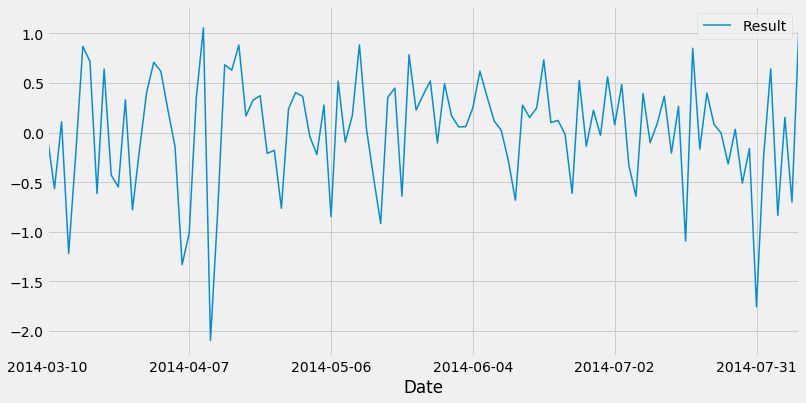

In [6]:
snp_date_result.plot('Date', 'Result', grid=True, figsize=(12,6), linewidth=1.5)

**Add Results to Headlines**

Now let's add these results to the headline from the same day. Later, we'll also look at shifting the results, so that, for example, headlines from March 10 would have a result from March 11 under the hypothesis that there is a lag between the impact of headlines on the market result. Right now, we'll stick to the idea that information flow is near real-time and that headlines from one date will affect the market result that same date.

In [7]:
# create copy of headlines df
headlines_results = joined_headlines.loc[:, ['TITLE', 'TIMESTAMP']]
results_list = []

# transform headlines by adding the S&P result for that day as a new column
# find the result for the date, then add it, or 0 if no result exists
for headline in headlines_results.iterrows():
    date = headline[1]['TIMESTAMP']
    result_series = snp_date_result.loc[lambda x: x['Date'] == date, 'Result']

    if result_series.empty:
        result = 0
    else:
        result = result_series.values[0]
    results_list.append(result)
    
headlines_results['RESULTS'] = results_list

print headlines_results.head()

                                               TITLE   TIMESTAMP   RESULTS
0   Fed official says weak data caused by weather...  2014-03-10 -0.036741
1  Bon-Ton CEO to resign Bon-Ton's 'whiz kid' CEO...  2014-03-11 -0.565950
2  Premier says China flexible on growth target L...  2014-03-13 -1.215589
3  Alibaba prepares for US IPO Alibaba Prepares F...  2014-03-17  0.869319
4  Euro Rescue Fund Challenges Rejected by German...  2014-03-18  0.717081


## Modeling

### Overview

In this section, our goal is to build a model that is going to accurately predict a result for a given headline. There are several ways to tackle this problem, but given our current label format, i.e., a continuous number between -2 and 1, it's logical to begin with a simple linear regression. We can use phase shifts of the results as mapped to the date (for instance, moving a result to the 'day after' from its current 'day of' mapping) to determine any impact on a regression model.

We can also turn this into a classification problem. There are a few ways to do it, for instance, classifying any result of -.1 or worse as a negative outcome, -.1 to .1 as neutral, and .1 or greater as positive. Other classifications could modify the buckets to greater granularity (e.g., very negative vs. slightly negative).

### Data Split

Normally to split our data, we'd use a random sampling function, such as scikit-learn's built-in '''train_test_split''', but given that we'd likely end up sampling extremely similar headlines for our testing set as found in the training set, we're going to have to split the data another way. For our purposes, we're going to take about 20% of the data from the tail end (by date) and make that our testing set. This is going to preserve better independence between our training and testing sets.

In [8]:
import numpy as np
from sklearn.utils import shuffle

# init lists for our features/labels (and dates for use later)
features = []
labels = []
dates = []
# grab our ndarray values
nested_headlines = headlines_results.loc[:,['TITLE']].values.tolist()
nested_labels = headlines_results.loc[:,['RESULTS']].values.tolist()
nested_dates = headlines_results.loc[:, ['TIMESTAMP']].values.tolist()
dates = np.unique(nested_dates)

# turn them into non-nested lists
for i in range(0, len(nested_headlines)):
    features.append(nested_headlines[i][0])
    labels.append(nested_labels[i][0])

# split the lists into train+test sets ~80/20
# there are 60 features/labels per day over 102 days, meaning we'll split it 4800/1320
X_train_raw = features[:80]
X_test_raw = features[80:]
y_train_raw = labels [:80]
y_test_raw = labels[80:]
X_train, y_train = shuffle(X_train_raw, y_train_raw, random_state=14)
X_test, y_test = shuffle(X_test_raw, y_test_raw, random_state=14)

print 'Training Set Size: ', len(X_train)
print 'Testing Set Size: ', len(X_test)

Training Set Size:  80
Testing Set Size:  22


### Feature Extraction

With the data split into training and testing sets, it's time to turn our strings of headlines into word counts, which we can then use as a statistic for creating a model of how those word frequencies impact our stock result and likewise, predicting unseen strings in our test set using that frequency data. We'll also break-up the strings into bigrams (two word 'n-grams') that our model can use to determine whether the frequency of words next to each other has a correlation to our results.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# init a 'vectorizer' to count both single words and bigrams
count_vect = CountVectorizer(ngram_range=(1,2), stop_words='english')
# fit the vectorizer with our training set and transform that set
X_train_counts = count_vect.fit_transform(X_train)
# transform our test set
X_test_counts = count_vect.transform(X_test)
# convert those occurrences to 'term frequency times inverse document frequency' (tf-idf),
# which will provide context for word/bigram counts based on the corpus
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

print 'Training Set Size & Num. Frequencies: ', X_train_tfidf.shape
print 'Testing Set Size & Num. Frequencies: ', X_test_tfidf.shape

Training Set Size & Num. Frequencies:  (80, 25816)
Testing Set Size & Num. Frequencies:  (22, 25816)


### Linear Regression: Least Squares & Ridge

With our training and testing data now transformed into something usable, we can build our linear regression models. Specifically, we'll use the standard Ordinary Least Squares model as our baseline and then kick-it up a notch with a Ridge Regression Cross-Validator model. (Sklearn's Ridge Regression model collection has a built-in cross-validator version.)

In [10]:
from sklearn import linear_model

# Ordinary Least Squares
ols_model = linear_model.LinearRegression()
ols_model.fit(X_train_tfidf, y_train)
ols_predictions = ols_model.predict(X_test_tfidf)

In [11]:
# Ridge Regression with built-in cross-validation
# NB: 'alpha' is a parameter imposing a penalty on complexity
ridge_model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge_model.fit(X_train_tfidf, y_train)
ridge_predictions = ridge_model.predict(X_test_tfidf)

### Linear Regression: Visualization

Let's take a look at what our models produce, specifically be examining a visualization of the error by data point between our predictions and actuals. I think it would be useful to first see a side-by-side line graph of my least squares regression and my ridge regression errors, as measured by the squared error. Then, let's look at the frequency of values, which is a good snapshot of how close or far the overall distribution of the predictions are compared to the actuals, albeit not a visualization of error per se.

[]

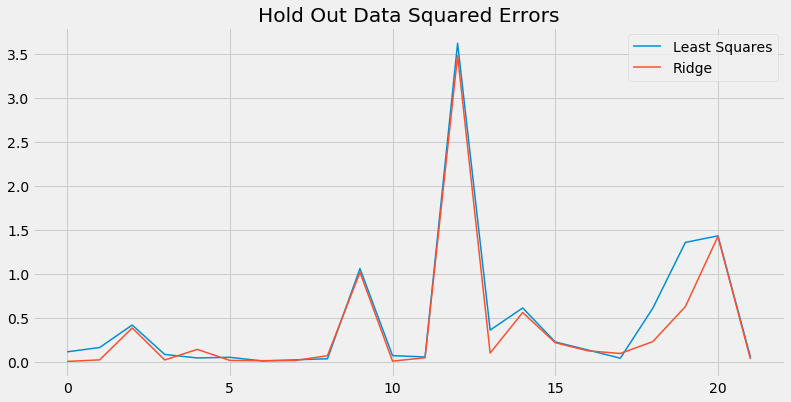

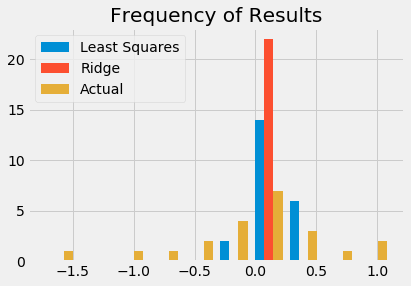

In [12]:
import math

# calculate square error for both types of linear regression predictions
ols_sqerrs = []
ridge_sqerrs = []
for i in range(0, len(ols_predictions)):
    # least squares
    ols_sqerr = math.pow(ols_predictions[i] - y_test[i], 2)
    ols_sqerrs.append(ols_sqerr)
    # ridge
    ridge_sqerr = math.pow(ridge_predictions[i] - y_test[i], 2)
    ridge_sqerrs.append(ridge_sqerr)

# plot square errors as a line graph
sqerr = plt
sqerr.figure(figsize=(12,6)) # extend size of graph
sqerr.plot(ols_sqerrs, linewidth=1.5, label='Least Squares')
sqerr.plot(ridge_sqerrs, linewidth=1.5, label='Ridge')
sqerr.legend()
sqerr.title('Hold Out Data Squared Errors')

# plot frequency of results (%gain or loss) as histogram
hist = plt
fig_hist, ax_hist = hist.subplots()
ax_hist.hist([ols_predictions, ridge_predictions, y_test], label=['Least Squares', 'Ridge', 'Actual'])
ax_hist.legend()
ax_hist.set_title('Frequency of Results')
hist.plot()

### Linear Regression: Performance

Judging by the visuals above, our performance looks terrible for the purposes of our predictions (i.e., making daily investment decisions). Both models maintain follow each other closely, so Ridge Regression does not provide much, if any of an advantage, and our distribution shows that our model is way off our actuals. Let's look at some hard numbers.

In [13]:
from sklearn import metrics

print '================  Linear Regression  ===================='
print 'Mean Squared Error: ', metrics.mean_squared_error(y_test, ols_predictions)
print 'R2 Score: ', metrics.r2_score(y_test, ols_predictions)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test, ols_predictions)
print ' '
print '================  Ridge Regression  ===================='
print 'Ridge Alpha Used: ', ridge_model.alpha_
print 'Mean Squared Error: ', metrics.mean_squared_error(y_test, ridge_predictions)
print 'R2 Score: ', metrics.r2_score(y_test, ridge_predictions)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test, ridge_predictions)

================  Linear Regression  ====================
Mean Squared Error:  0.478000794928
R2 Score:  -0.339390550366
Explained Variance Score:  -0.219770327824
 
================  Ridge Regression  ====================
Ridge Alpha Used:  10.0
Mean Squared Error:  0.390508617936
R2 Score:  -0.0942315541107
Explained Variance Score:  -0.0142778001813


### Linear Regression: Label Shifting

Our performance above for linear regression models, given the assignment of results to that day's headlines, is quite bad. Ridge Regression using cross-validation does somewhat better than the straight-forward Ordinary Least Squares approach, but still, our MSE is nearly 0.4. Our correlation coefficient measures show that we're doing worse than a horizontal line in terms of fit, which makes sense because our linear plot in both models is essentially a horizontal line.

Before packing it in on linear regression altogether, let's try shifting the headlines to align to the next day's S&P results, testing the hypothesis that it make take a day before good or bad headlines to sink in.

**Transform**

In [14]:
# transform a new pandas df with newly assigned results
headlines_dayafter_results = headlines_results.copy()
snp_dayafter_result = snp_date_result.copy()
# shift results forward a day so that the next day's results are now assigned to the date
snp_dayafter_result['Result'] = snp_dayafter_result['Result'].shift(-1)
dayafter_results_list = []
# pull out the result for the corresponding date and add it to our dataframe
for headline in headlines_dayafter_results.iterrows():
    date = headline[1]['TIMESTAMP']
    result_series = snp_dayafter_result.loc[lambda x: x['Date'] == date, 'Result']
    if result_series.empty:
        result = 0
    else:
        result = result_series.values[0]
        if math.isnan(result):   # this data produces at least one NaN result
            result = 0
    dayafter_results_list.append(result)
    
headlines_dayafter_results['RESULTS'] = dayafter_results_list

# init lists for our features/labels
dayafter_features = []
dayafter_labels = []
# grab our ndarray values
nested_dayafter_features = headlines_dayafter_results.loc[:,['TITLE']].values.tolist()
nested_dayafter_labels = headlines_dayafter_results.loc[:,['RESULTS']].values.tolist()

# turn them into non-nested lists
for i in range(0, len(nested_dayafter_features)):
    dayafter_features.append(nested_dayafter_features[i][0])
    dayafter_labels.append(nested_dayafter_labels[i][0])

# split the lists into train+test sets 80/20
X_dayafter_train_raw = dayafter_features[:80]
X_dayafter_test_raw = dayafter_features[80:]
y_dayafter_train_raw = dayafter_labels[:80]
y_dayafter_test_raw = dayafter_labels[80:]

X_dayafter_train, y_dayafter_train = shuffle(X_dayafter_train_raw, y_dayafter_train_raw, random_state=14)
X_dayafter_test, y_dayafter_test = shuffle(X_dayafter_test_raw, y_dayafter_test_raw, random_state=14)

# init a 'vectorizer' to count both single words and bigrams
dayafter_count_vect = CountVectorizer(ngram_range=(2,2), stop_words='english')
# fit the vectorizer with our training set and transform that set
X_dayafter_train_counts = dayafter_count_vect.fit_transform(X_dayafter_train)
# transform our test set
X_dayafter_test_counts = dayafter_count_vect.transform(X_dayafter_test)
# convert those occurrences to 'term frequency times inverse document frequency' (tf-idf),
# which will provide context for word/bigram counts based on the corpus
dayafter_tfidf_transformer = TfidfTransformer()
X_dayafter_train_tfidf = dayafter_tfidf_transformer.fit_transform(X_dayafter_train_counts)
X_dayafter_test_tfidf = dayafter_tfidf_transformer.fit_transform(X_dayafter_test_counts)

print 'Training Set Size & Num. Frequencies: ', X_dayafter_train_tfidf.shape
print 'Testing Set Size & Num. Frequencies: ', X_dayafter_test_tfidf.shape

Training Set Size & Num. Frequencies:  (80, 20583)
Testing Set Size & Num. Frequencies:  (22, 20583)


**Model**

In [15]:
# re-run Ridge Regression with cross-validation, which performed better than OLS
dayafter_ridge_model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
dayafter_ridge_model.fit(X_dayafter_train_tfidf, y_dayafter_train)
dayafter_ridge_predictions = dayafter_ridge_model.predict(X_dayafter_test_tfidf)

**Performance**

In [16]:
print 'Ridge Alpha Used: ', dayafter_ridge_model.alpha_
print 'Mean Squared Error: ', metrics.mean_squared_error(y_dayafter_test, dayafter_ridge_predictions)
print 'R2 Score: ', metrics.r2_score(y_dayafter_test, dayafter_ridge_predictions)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_dayafter_test, dayafter_ridge_predictions)

Ridge Alpha Used:  10.0
Mean Squared Error:  0.318784541696
R2 Score:  -0.0969958539589
Explained Variance Score:  0.0108895069426


**Visualization**

[]

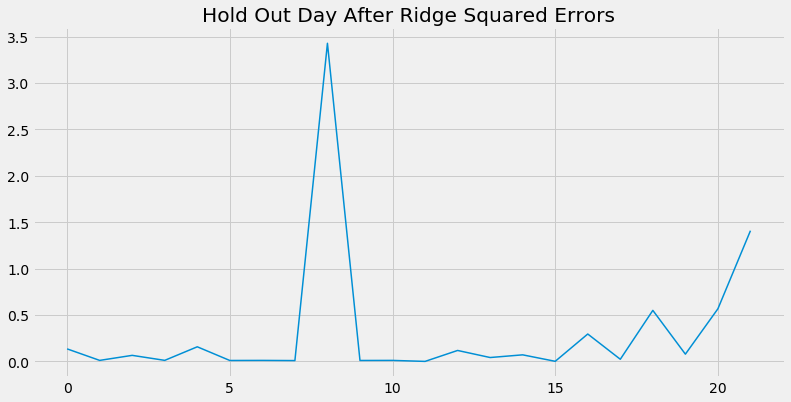

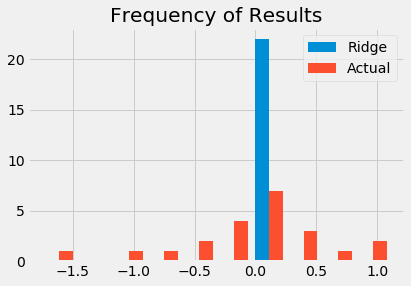

In [17]:
# calculate square error for ridge regression predictions
ridge_dayafter_sqerrs = []
for i in range(0, len(dayafter_ridge_predictions)):
    # ridge
    ridge_dayafter_sqerr = math.pow(dayafter_ridge_predictions[i] - y_dayafter_test[i], 2)
    ridge_dayafter_sqerrs.append(ridge_dayafter_sqerr)

# plot square errors as a line graph
dayafter_sqerr = plt
dayafter_sqerr.figure(figsize=(12,6)) # extend size of graph
dayafter_sqerr.plot(ridge_dayafter_sqerrs, linewidth=1.5)
dayafter_sqerr.title('Hold Out Day After Ridge Squared Errors')

# plot frequency of results (%gain or loss) as histogram
dayafter_hist = plt
fig_hist, dayafter_ax_hist = dayafter_hist.subplots()
dayafter_ax_hist.hist([dayafter_ridge_predictions, y_test], label=['Ridge', 'Actual'])
dayafter_ax_hist.legend()
dayafter_ax_hist.set_title('Frequency of Results')
dayafter_hist.plot()

### Analysis and Transition

Our results for the phase shifted labels (day after results) are still quite dismal. We can see that our model just plops everything down the center -- a horizontal line -- which lowers the MSE (better than day of anyway!), but doesn't perform much better at explaining the variance. Linear models aren't going to cut it for prediction-making, unless we're making investment decisions by coin flip.

### Classification: Overview

To move from linear regression to classification, we're going to have to start by transforming our data into classifiable categories from their continuous values. For our models, we're going to use Naive Bayes, which as its name portends is a probabilistic learner, and a Support Vector Machine classifier that uses Stochastic Gradient Descent. More discussion on the models themselves can be found below. Finally, we'll look at performance, although here's we'll have (in my view) stronger metrics on which to base our judgment for how well we're making predictions. With linear regression, we can identify correlation and how well the model (curve) explains the variance of the data, but using classification, we can determine meaasures such as accuracy and scoring metrics such as F1, using the break-out of our correctly and incorrectly identified predictions. Or in other words, categories, as opposed to producing a continuous value measured against another continuous value can give more discrete ways to measure our models.

### Classification: Transforming Our Data Into Categories

To train our classifiers, we're going to have to bucket our continuous labels into categories. Let's use positive, negative, and neutral. Not having a trading strategy to inform our decision as to the upper and lower bounds of a neutral category (with our other two categories essentially building outward from the neutral bounds), we'll use the intuition that a tenth of a percent around 0 qualifies as a neutral trading day. That means that any gains over 0.05% and any losses under -0.05% shall qualify for those respective categories. Again, if we had a trading strategy that valued investing only on big gain days to guide our decision-making, we'd have to re-work our boundary assignments here.

It's also worthwhile to note here that we're going to test both "day of" results and "day after" results below, as indicated in the output and code comments.

In [18]:
# transform continuous labels to -1, 0, 1 categorical labels
y_class_dayof_train = []
y_class_dayof_test = []
y_class_dayafter_train = []
y_class_dayafter_test = []

for value in y_train:
    if value > 0.4:
        y_class_dayof_train.append(1)
    elif 0.4 >= value >= 0:
        y_class_dayof_train.append(0)
    else:
        y_class_dayof_train.append(-1)

for value in y_test:
    if value > 0.4:
        y_class_dayof_test.append(1)
    elif 0.4 >= value >= 0:
        y_class_dayof_test.append(0)
    else:
        y_class_dayof_test.append(-1)
        
for value in y_dayafter_train:
    if value > 0.4:
        y_class_dayafter_train.append(1)
    elif 0.4 >= value >= 0:
        y_class_dayafter_train.append(0)
    else:
        y_class_dayafter_train.append(-1)

for value in y_dayafter_test:
    if value > 0.4:
        y_class_dayafter_test.append(1)
    elif 0.4 >= value >= 0:
        y_class_dayafter_test.append(0)
    else:
        y_class_dayafter_test.append(-1)

print 'Training Features: {}'.format(X_train_tfidf.shape)
print 'Training Day Of Labels: {}'.format(len(y_class_dayof_train))
print 'Training Day After Labels: {}'.format(len(y_class_dayafter_train))
print '====================================='
for i in range(0,5):
    print 'Continuous value {} maps to {}'.format(y_train[i], y_class_dayof_train[i])

Training Features: (80, 25816)
Training Day Of Labels: 80
Training Day After Labels: 80
Continuous value 0.364923290586 maps to 0
Continuous value 0.640831584379 maps to 1
Continuous value 0.372755261554 maps to 0
Continuous value -1.2155892418 maps to -1
Continuous value 0.0 maps to 0


### Classification: Visualization

We can see that our four-tenths of a percent neutral category captures most of our training data, accounting for 50% if using day of labels or just over 52% if using day after. While this effectively overweights for a neutral categorization, it also splits our positive and negative categories out nicely, so we'll stick with it as a data split.

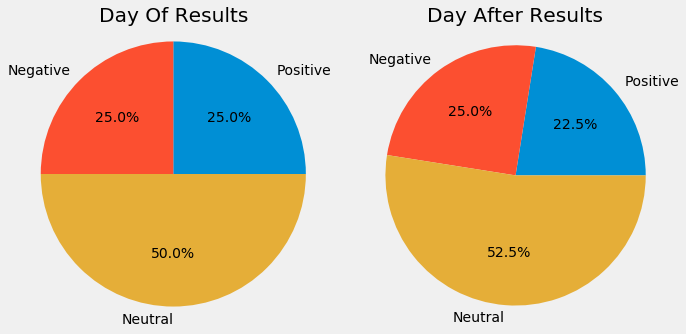

Day Of Results
----------------
Positive:  20
Negative: 20
Neutral:  40


In [19]:
# break-out the data by category for a pie chart display

# labels for the chart
pie_labels = 'Positive', 'Negative', 'Neutral'
# initialize values for the labels
pie_values1 = [0] * 3
pie_values2 = [0] * 3
# populate the values from the transformed data
for value in y_class_dayof_train:
    if value == 1:
        pie_values1[0] += 1
    elif value == -1:
        pie_values1[1] += 1
    elif value == 0:
        pie_values1[2] += 1

for value in y_class_dayafter_train:
    if value == 1:
        pie_values2[0] += 1
    elif value == -1:
        pie_values2[1] += 1
    elif value == 0:
        pie_values2[2] += 1
        
# pie chart plot config
fig, axes = plt.subplots(figsize=(10,5), ncols=2)
ax1, ax2 = axes.flatten()
ax1.pie(pie_values1, labels=pie_labels, autopct='%1.1f%%')
ax1.set_title('Day Of Results')
ax1.axis('equal')
ax2.pie(pie_values2, labels=pie_labels, autopct='%1.1f%%')
ax2.set_title('Day After Results')
ax2.axis('equal')

plt.show()

print 'Day Of Results'
print '----------------'
print 'Positive: ', pie_values1[0]
print 'Negative:', pie_values1[1]
print 'Neutral: ', pie_values1[2]

### Classification: Naive Bayes & Support Vector Machine



In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# NB Models for Day Of and Day After
nb_dayof_model = MultinomialNB().fit(X_train_tfidf, y_class_dayof_train)
nb_dayof_predictions = nb_dayof_model.predict(X_test_tfidf)

nb_dayafter_model = MultinomialNB().fit(X_train_tfidf, y_class_dayafter_train)
nb_dayafter_predictions = nb_dayafter_model.predict(X_test_tfidf)

# SVM Models for Day Of and Day After
svm_dayof_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=14)
svm_dayof_model.fit(X_train_tfidf, y_class_dayof_train)
svm_dayof_predictions = svm_dayof_model.predict(X_test_tfidf)

svm_dayafter_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=14)
svm_dayafter_model.fit(X_train_tfidf, y_class_dayafter_train)
svm_dayafter_predictions = svm_dayafter_model.predict(X_test_tfidf)

pos_neg_neut = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}

print 'Multinomial Naive Bayes Day Of'
print 'Headline                                                                  S&P Result'
print '------------------------------------------------------------------------------------'
for i in range(0, 5):
    print 'Day {0} {1:10}'.format(i, pos_neg_neut[nb_dayof_predictions[i]])
print '==================================================================================='
print 'Support Vector Machine Day Of'
print 'Headline                                                                  S&P Result'
print '------------------------------------------------------------------------------------'
for i in range(0, 5):
    print 'Day {0} {1:10}'.format(i, pos_neg_neut[svm_dayof_predictions[i]])

Multinomial Naive Bayes Day Of
Headline                                                                  S&P Result
------------------------------------------------------------------------------------
Day 0 Neutral   
Day 1 Neutral   
Day 2 Neutral   
Day 3 Neutral   
Day 4 Neutral   
Support Vector Machine Day Of
Headline                                                                  S&P Result
------------------------------------------------------------------------------------
Day 0 Positive  
Day 1 Positive  
Day 2 Neutral   
Day 3 Neutral   
Day 4 Negative  


### Classification: Performance

Our sample above looks good, but let's see how well the model performs over the entirety of the test data. (Spoiler: Not so good!)

In [21]:
from sklearn import metrics

print '================  Naive Bayes Day Of ===================='
print metrics.classification_report(y_class_dayof_test, nb_dayof_predictions, labels=[1, -1, 0], target_names=['Positive', 'Negative', 'Neutral'])
print 'Overall Accuracy: {0:.2f}%'.format(np.mean(nb_dayof_predictions == y_class_dayof_test))
print ' '
print '=================     SVM Day Of    ====================='
print metrics.classification_report(y_class_dayof_test, svm_dayof_predictions, labels=[1, -1, 0], target_names=['Positive', 'Negative', 'Neutral'])
print 'Overall Accuracy: {0:.2f}%'.format(np.mean(svm_dayof_predictions == y_class_dayof_test))
print ' '
print '================  Naive Bayes  Day After ===================='
print metrics.classification_report(y_class_dayafter_test, nb_dayafter_predictions, labels=[1, -1, 0], target_names=['Positive', 'Negative', 'Neutral'])
print 'Overall Accuracy: {0:.2f}%'.format(np.mean(nb_dayafter_predictions == y_class_dayafter_test))
print ' '
print '=================     SVM Day After    ====================='
print metrics.classification_report(y_class_dayafter_test, svm_dayafter_predictions, labels=[1, -1, 0], target_names=['Positive', 'Negative', 'Neutral'])
print 'Overall Accuracy: {0:.2f}%'.format(np.mean(svm_dayafter_predictions == y_class_dayafter_test))

================  Naive Bayes Day Of ====================
             precision    recall  f1-score   support

   Positive       0.00      0.00      0.00         4
   Negative       0.00      0.00      0.00         9
    Neutral       0.41      1.00      0.58         9

avg / total       0.17      0.41      0.24        22

Overall Accuracy: 0.41%
 
=================     SVM Day Of    =====================
             precision    recall  f1-score   support

   Positive       0.00      0.00      0.00         4
   Negative       0.00      0.00      0.00         9
    Neutral       0.29      0.44      0.35         9

avg / total       0.12      0.18      0.14        22

Overall Accuracy: 0.18%
 
================  Naive Bayes  Day After ====================
             precision    recall  f1-score   support

   Positive       0.00      0.00      0.00         3
   Negative       0.00      0.00      0.00         8
    Neutral       0.50      1.00      0.67        11

avg / total       0.

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Classification: Parameter Tuning

So, we have some dismal performance using the basic model parameters. Let's see if we can tune the SVM model into better performance, or if it's time to go back to the drawing board.

In [22]:
from sklearn.model_selection import GridSearchCV
# map of parameters to use in tuning
parameters = {
    'loss': ['hinge', 'log', 'perceptron'],
    'penalty': ['none', 'l2', 'l1'],
    'alpha': [0.1, 1e-2, 1e-3, 1e-4],
    'n_iter': [3, 5, 8]
}
# invoke, fit, and predict
tuner_dayof_clf = GridSearchCV(svm_dayof_model, parameters)
tuner_dayof_clf.fit(X_train_tfidf, y_class_dayof_train)
tuned_dayof_predictions = tuner_dayof_clf.predict(X_test_tfidf)

tuner_dayafter_clf = GridSearchCV(svm_dayafter_model, parameters)
tuner_dayafter_clf.fit(X_train_tfidf, y_class_dayafter_train)
tuned_dayafter_predictions = tuner_dayafter_clf.predict(X_test_tfidf)

# performance
print '========  Tuned Day Of SVM  ============'
print metrics.classification_report(y_class_dayof_test, tuned_dayof_predictions, labels=[1, -1, 0], target_names=['Positive', 'Negative', 'Neutral'])
print 'Overall Accuracy: {0:.2f}%'.format(np.mean(tuned_dayof_predictions == y_class_dayof_test))
print 'Parameters Used:'
for parameter in parameters.keys():
    print '{}: {}'.format(parameter, tuner_dayof_clf.best_params_[parameter])
print ' '
print '========  Tuned Day After SVM  ============'
print metrics.classification_report(y_class_dayafter_test, tuned_dayafter_predictions, labels=[1, -1, 0], target_names=['Positive', 'Negative', 'Neutral'])
print 'Overall Accuracy: {0:.2f}%'.format(np.mean(tuned_dayafter_predictions == y_class_dayafter_test))
print 'Parameters Used:'
for parameter in parameters.keys():
    print '{}: {}'.format(parameter, tuner_dayafter_clf.best_params_[parameter])

========  Tuned Day Of SVM  ============
             precision    recall  f1-score   support

   Positive       0.00      0.00      0.00         4
   Negative       0.00      0.00      0.00         9
    Neutral       0.41      1.00      0.58         9

avg / total       0.17      0.41      0.24        22

Overall Accuracy: 0.41%
Parameters Used:
penalty: l1
loss: hinge
n_iter: 3
alpha: 0.1
 
========  Tuned Day After SVM  ============
             precision    recall  f1-score   support

   Positive       0.00      0.00      0.00         3
   Negative       0.00      0.00      0.00         8
    Neutral       0.50      1.00      0.67        11

avg / total       0.25      0.50      0.33        22

Overall Accuracy: 0.50%
Parameters Used:
penalty: l2
loss: hinge
n_iter: 3
alpha: 0.1


### Conclusion: Examining Predictions vs. Actuals

What does it look like when we plot our Ridge prediction values against our actual values? Intuitively, are we making money and guessing the market correctly?

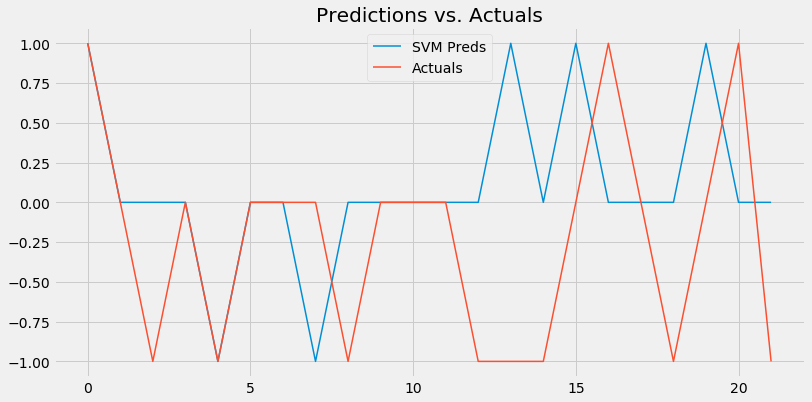

In [23]:
# plot predictions vs. actuals
pred_actual = plt
pred_actual.figure(figsize=(12,6)) # extend size of graph
pred_actual.plot(svm_dayafter_predictions, linewidth=1.5, label='SVM Preds')
pred_actual.plot(y_class_dayafter_test, linewidth=1.5, label='Actuals')
pred_actual.legend()
pred_actual.title('Predictions vs. Actuals')